
ENHANCED MULTI-CURRENCY STOCK PRICE PREDICTOR
Supports stocks from USA, India, UK, Germany, Japan, China and more!

AVAILABLE STOCKS FOR PREDICTION

China Stocks:
--------------------------------------------------------------------------------
  0700.HK         Tencent Holdings                    HK$   (HKEX)
  9988.HK         Alibaba Group                       HK$   (HKEX)

Germany Stocks:
--------------------------------------------------------------------------------
  SAP.DE          SAP SE                              €     (XETRA)
  VOW3.DE         Volkswagen AG                       €     (XETRA)

India Stocks:
--------------------------------------------------------------------------------
  RELIANCE.NS     Reliance Industries                 ₹     (NSE)
  TCS.NS          Tata Consultancy Services           ₹     (NSE)
  HDFCBANK.NS     HDFC Bank                           ₹     (NSE)
  INFY.NS         Infosys                             ₹     (NSE)
  WIPRO.NS        Wipro    

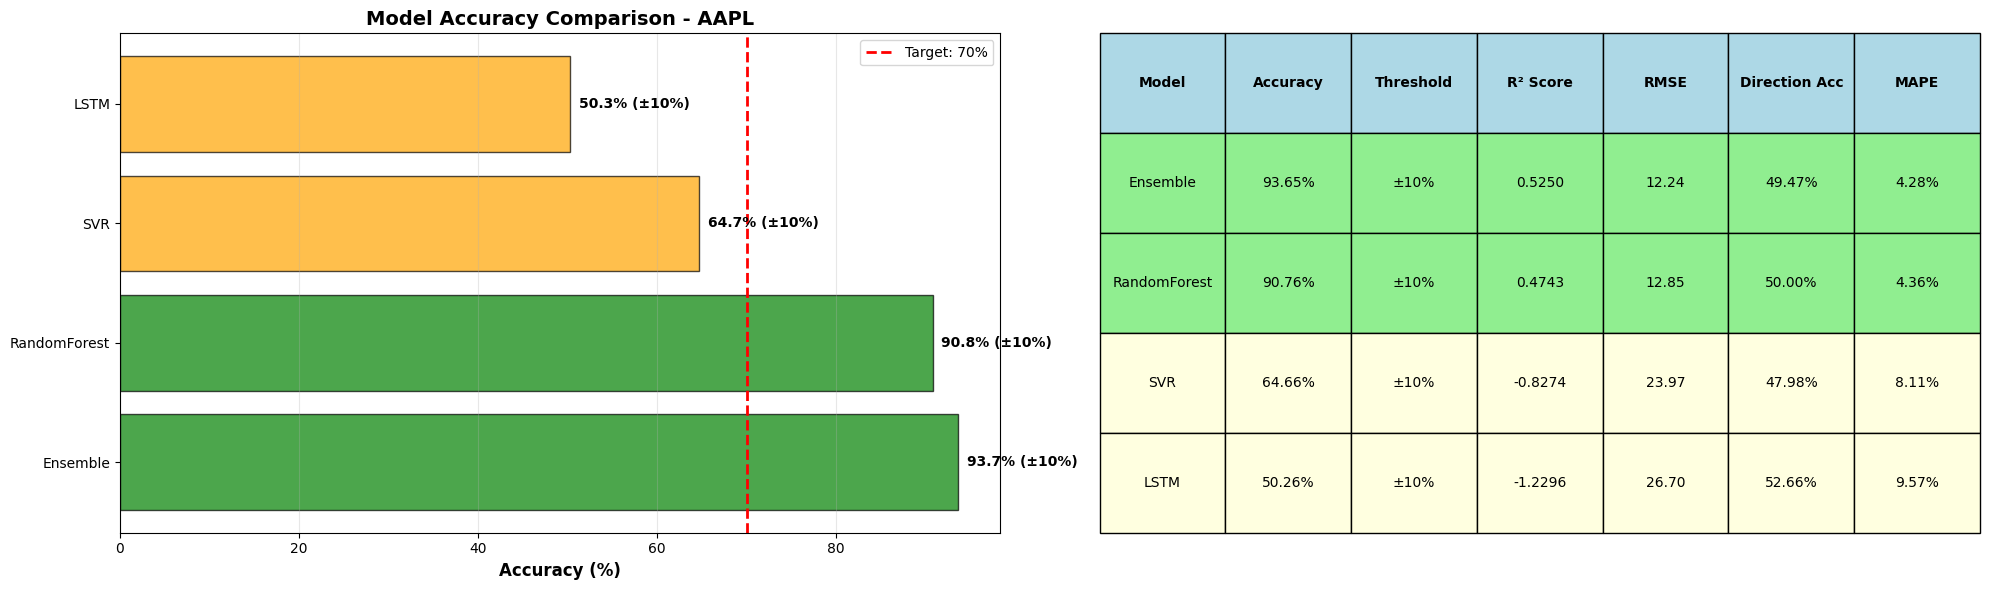

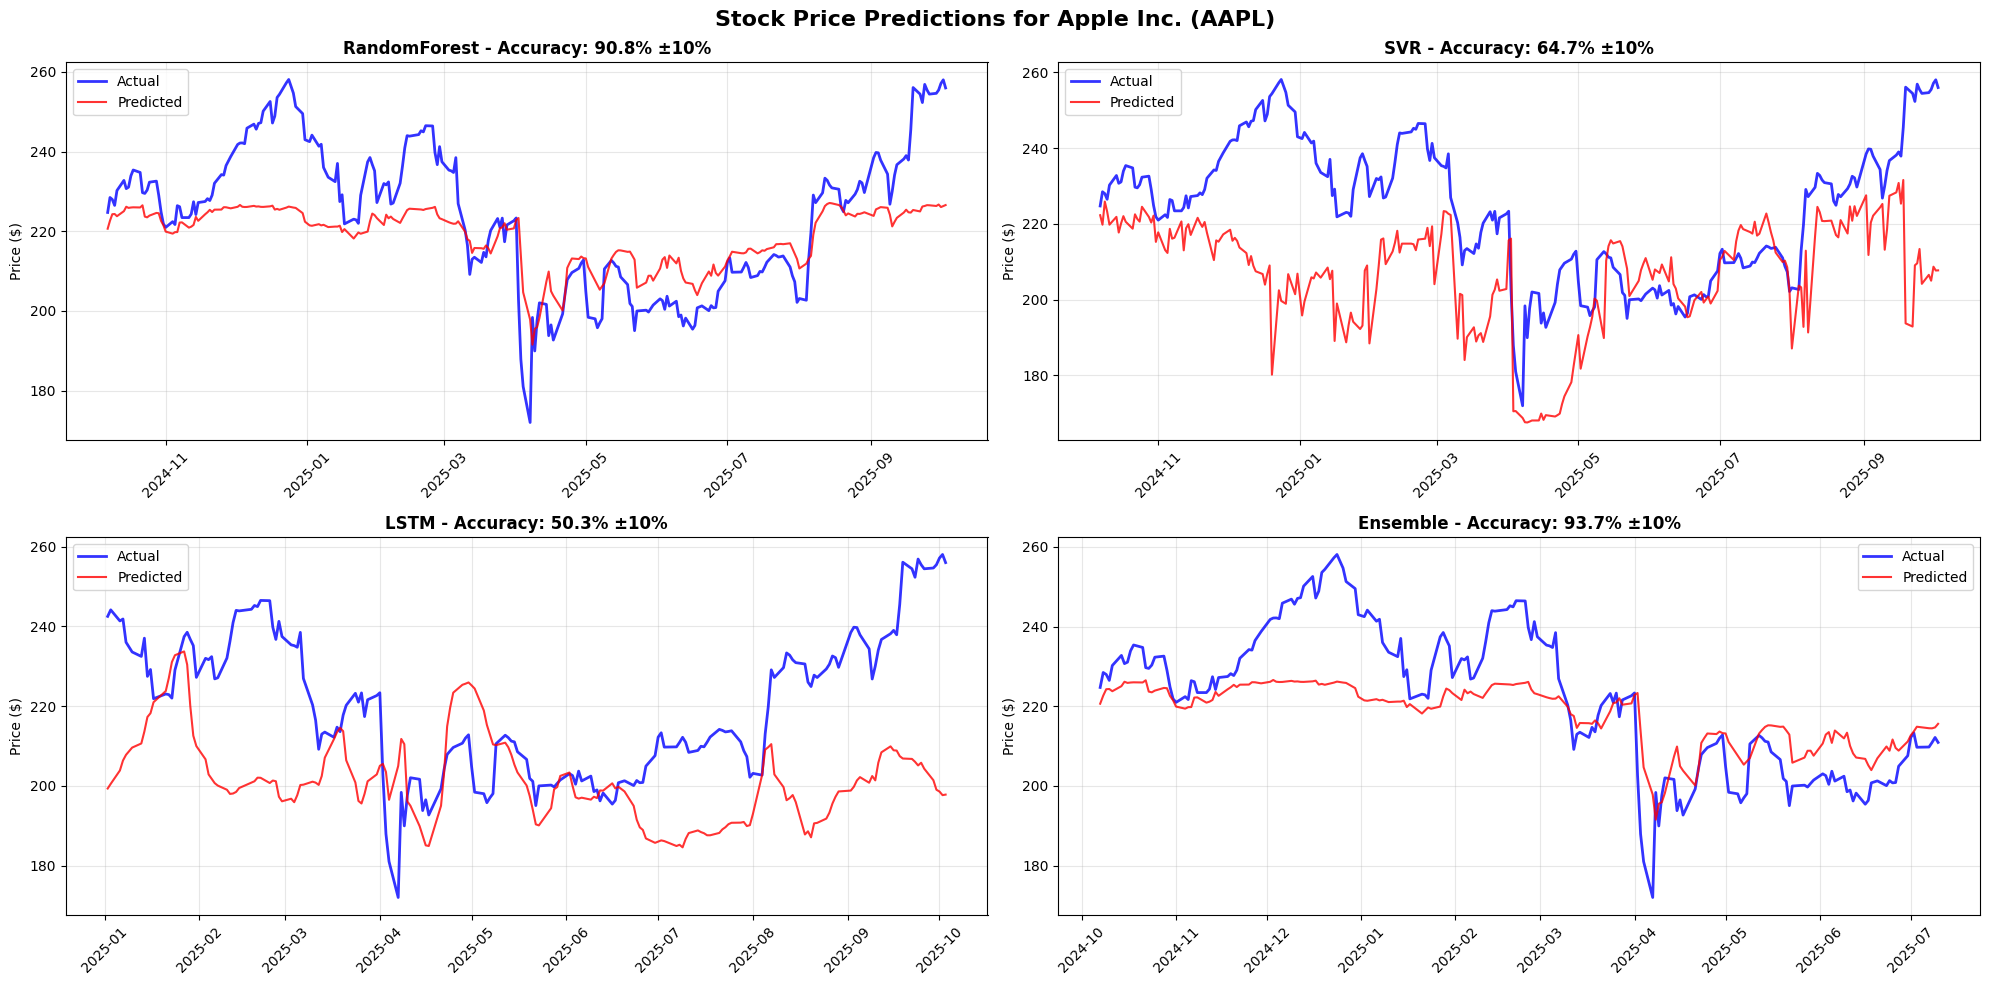


ANALYSIS COMPLETED SUCCESSFULLY!

Best Model: Ensemble
Accuracy: 93.65% at threshold ±10%
Currency: $

TOP 10 MOST IMPORTANT FEATURES (Random Forest)

    Feature  Importance
      Close    0.121339
        Low    0.104540
       High    0.093467
Close_Lag_1    0.080259
       Open    0.077899
       MA_5    0.072623
      EMA_5    0.062157
Close_Lag_7    0.040695
Close_Lag_3    0.036889
     EMA_10    0.036665


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Global stock database with currency symbols
STOCK_DATABASE = {
    # Indian Stocks (NSE)
    'RELIANCE.NS': {'name': 'Reliance Industries', 'country': 'India', 'currency': '₹', 'exchange': 'NSE'},
    'TCS.NS': {'name': 'Tata Consultancy Services', 'country': 'India', 'currency': '₹', 'exchange': 'NSE'},
    'HDFCBANK.NS': {'name': 'HDFC Bank', 'country': 'India', 'currency': '₹', 'exchange': 'NSE'},
    'INFY.NS': {'name': 'Infosys', 'country': 'India', 'currency': '₹', 'exchange': 'NSE'},
    'WIPRO.NS': {'name': 'Wipro', 'country': 'India', 'currency': '₹', 'exchange': 'NSE'},
    
    # US Stocks (NYSE/NASDAQ)
    'AAPL': {'name': 'Apple Inc.', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    'GOOGL': {'name': 'Alphabet Inc.', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    'MSFT': {'name': 'Microsoft Corporation', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    'AMZN': {'name': 'Amazon.com Inc.', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    'TSLA': {'name': 'Tesla Inc.', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    'META': {'name': 'Meta Platforms Inc.', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    'NVDA': {'name': 'NVIDIA Corporation', 'country': 'USA', 'currency': '$', 'exchange': 'NASDAQ'},
    
    # UK Stocks (LSE)
    'BP.L': {'name': 'BP plc', 'country': 'UK', 'currency': '£', 'exchange': 'LSE'},
    'HSBA.L': {'name': 'HSBC Holdings', 'country': 'UK', 'currency': '£', 'exchange': 'LSE'},
    'VOD.L': {'name': 'Vodafone Group', 'country': 'UK', 'currency': '£', 'exchange': 'LSE'},
    
    # German Stocks (XETRA)
    'SAP.DE': {'name': 'SAP SE', 'country': 'Germany', 'currency': '€', 'exchange': 'XETRA'},
    'VOW3.DE': {'name': 'Volkswagen AG', 'country': 'Germany', 'currency': '€', 'exchange': 'XETRA'},
    
    # Japanese Stocks (TSE)
    '7203.T': {'name': 'Toyota Motor', 'country': 'Japan', 'currency': '¥', 'exchange': 'TSE'},
    '6758.T': {'name': 'Sony Group', 'country': 'Japan', 'currency': '¥', 'exchange': 'TSE'},
    
    # Chinese Stocks (Hong Kong)
    '0700.HK': {'name': 'Tencent Holdings', 'country': 'China', 'currency': 'HK$', 'exchange': 'HKEX'},
    '9988.HK': {'name': 'Alibaba Group', 'country': 'China', 'currency': 'HK$', 'exchange': 'HKEX'},
}

class StockPricePredictor:
    def __init__(self, symbol, period="2y"):
        self.symbol = symbol
        self.period = period
        self.data = None
        self.scaler = StandardScaler()
        self.models = {}
        self.predictions = {}
        self.metrics = {}
        
        # Get stock info
        if symbol in STOCK_DATABASE:
            self.stock_info = STOCK_DATABASE[symbol]
        else:
            self.stock_info = {'name': symbol, 'country': 'Unknown', 'currency': '$', 'exchange': 'Unknown'}
    
    def fetch_data(self):
        """Fetch stock data using yfinance"""
        print(f"\nFetching data for {self.stock_info['name']} ({self.symbol})")
        print(f"Exchange: {self.stock_info['exchange']} | Currency: {self.stock_info['currency']}")
        try:
            self.data = yf.download(self.symbol, period=self.period, auto_adjust=True, progress=False)
            if self.data.empty:
                raise ValueError(f"No data found for symbol {self.symbol}")
            
            print(f"Original data shape: {self.data.shape}")
            
            if isinstance(self.data.columns, pd.MultiIndex):
                self.data.columns = [col[0] for col in self.data.columns]
            
            self.create_technical_indicators()
            print(f"Data with indicators shape: {self.data.shape}")
            return self.data
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None
    
    def create_technical_indicators(self):
        """Create technical indicators for better prediction"""
        try:
            if len(self.data) < 50:
                print("Warning: Not enough data for all technical indicators")
                return
            
            df = self.data.copy()
            
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [col[0] for col in df.columns]
            
            # Price-based features
            for window in [5, 10, 20, 50]:
                df[f'MA_{window}'] = df['Close'].rolling(window=window, min_periods=1).mean()
                df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
            
            # Price momentum
            df['Price_Change'] = df['Close'].diff()
            df['Price_Change_Pct'] = df['Close'].pct_change()
            df['Price_ROC'] = df['Close'].pct_change(periods=10)
            
            # RSI
            df['RSI'] = self.calculate_rsi(df['Close'], 14)
            df['RSI_Fast'] = self.calculate_rsi(df['Close'], 7)
            
            # MACD
            exp12 = df['Close'].ewm(span=12, adjust=False).mean()
            exp26 = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = exp12 - exp26
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
            
            # Bollinger Bands
            bb_middle = df['Close'].rolling(window=20, min_periods=1).mean()
            bb_std = df['Close'].rolling(window=20, min_periods=1).std()
            df = df.assign(
                BB_Middle=bb_middle,
                BB_Upper=bb_middle + (bb_std * 2),
                BB_Lower=bb_middle - (bb_std * 2)
            )
            df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
            df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
            
            # Stochastic Oscillator
            low_min = df['Low'].rolling(14, min_periods=1).min()
            high_max = df['High'].rolling(14, min_periods=1).max()
            df['STOCH_K'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100
            df['STOCH_D'] = df['STOCH_K'].rolling(3, min_periods=1).mean()
            
            # Volume indicators
            df['Volume_MA'] = df['Volume'].rolling(window=10, min_periods=1).mean()
            df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
            df['Volume_ROC'] = df['Volume'].pct_change(periods=5)
            
            # Volatility indicators
            df['Volatility'] = df['Close'].rolling(window=20, min_periods=1).std()
            df['True_Range'] = self.calculate_true_range(df)
            df['ATR'] = df['True_Range'].rolling(window=14, min_periods=1).mean()
            df['ATR_Pct'] = (df['ATR'] / df['Close']) * 100
            
            # Support and Resistance
            df['Resistance'] = df['High'].rolling(window=20, min_periods=1).max()
            df['Support'] = df['Low'].rolling(window=20, min_periods=1).min()
            df['Price_To_Resistance'] = df['Close'] / df['Resistance']
            df['Price_To_Support'] = df['Close'] / df['Support']
            
            # Additional features
            df['HL_Ratio'] = (df['High'] - df['Low']) / df['Close']
            df['OC_Ratio'] = (df['Close'] - df['Open']) / df['Open']
            df['HL_Pct'] = (df['High'] - df['Low']) / df['Low'] * 100
            
            # Lag features (more lags for better LSTM performance)
            for lag in [1, 2, 3, 5, 7]:
                df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
                df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
                df[f'RSI_Lag_{lag}'] = df['RSI'].shift(lag)
            
            # Price acceleration and momentum
            df['Price_Acceleration'] = df['Price_Change_Pct'].diff()
            df['Momentum'] = df['Close'] - df['Close'].shift(4)
            
            # Trend indicators
            df['Trend_Strength'] = (df['MA_20'] - df['MA_50']) / df['MA_50']
            
            self.data = df
            
            initial_len = len(self.data)
            self.data = self.data.dropna()
            final_len = len(self.data)
            print(f"Dropped {initial_len - final_len} rows with NaN values. Final shape: {self.data.shape}")
            
        except Exception as e:
            print(f"Error creating technical indicators: {e}")
            import traceback
            traceback.print_exc()
    
    def calculate_rsi(self, prices, window=14):
        """Calculate Relative Strength Index"""
        try:
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi
        except Exception as e:
            print(f"Error calculating RSI: {e}")
            return pd.Series([50] * len(prices), index=prices.index)
    
    def calculate_true_range(self, df):
        """Calculate True Range for ATR"""
        try:
            high_low = df['High'] - df['Low']
            high_close_prev = np.abs(df['High'] - df['Close'].shift(1))
            low_close_prev = np.abs(df['Low'] - df['Close'].shift(1))
            true_range = np.maximum(high_low, np.maximum(high_close_prev, low_close_prev))
            return true_range
        except Exception as e:
            print(f"Error calculating True Range: {e}")
            return high_low
    
    def prepare_features(self, lookback_days=60, test_size=0.2):
        """Prepare features for training"""
        try:
            exclude_columns = []
            feature_columns = [col for col in self.data.columns if col not in exclude_columns]
            
            print(f"Available features: {len(feature_columns)}")
            
            X = self.data[feature_columns].values
            y = self.data['Close'].shift(-1).values
            
            X = X[:-1]
            y = y[:-1]
            
            if len(X) < lookback_days * 2:
                lookback_days = min(30, len(X) // 2)
                print(f"Reducing lookback days to {lookback_days} due to limited data")
            
            split_idx = int(len(X) * (1 - test_size))
            self.X_train, self.X_test = X[:split_idx], X[split_idx:]
            self.y_train, self.y_test = y[:split_idx], y[split_idx:]
            self.dates_train, self.dates_test = self.data.index[:split_idx], self.data.index[split_idx:-1]
            
            print(f"Training set: {len(self.X_train)} samples")
            print(f"Testing set: {len(self.X_test)} samples")
            
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
            self.X_test_scaled = self.scaler.transform(self.X_test)
            
            self.X_train_lstm, self.y_train_lstm = self.create_lstm_dataset(self.X_train_scaled, self.y_train, lookback_days)
            self.X_test_lstm, self.y_test_lstm = self.create_lstm_dataset(self.X_test_scaled, self.y_test, lookback_days)
            
            print(f"LSTM Training set: {self.X_train_lstm.shape}")
            print(f"LSTM Testing set: {self.X_test_lstm.shape}")
            
            return True
            
        except Exception as e:
            print(f"Error preparing features: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    def create_lstm_dataset(self, X, y, lookback_days=60):
        """Create dataset for LSTM"""
        try:
            X_lstm, y_lstm = [], []
            for i in range(lookback_days, len(X)):
                X_lstm.append(X[i-lookback_days:i])
                y_lstm.append(y[i])
            
            if len(X_lstm) == 0:
                raise ValueError("Not enough data for LSTM training")
                
            return np.array(X_lstm), np.array(y_lstm)
        except Exception as e:
            print(f"Error creating LSTM dataset: {e}")
            return np.array([]), np.array([])
    
    def train_random_forest(self):
        """Train Random Forest model"""
        try:
            print("Training Random Forest...")
            rf_model = RandomForestRegressor(
                n_estimators=300,
                max_depth=25,
                random_state=42,
                n_jobs=-1,
                min_samples_split=4,
                min_samples_leaf=2,
                max_features='sqrt'
            )
            rf_model.fit(self.X_train_scaled, self.y_train)
            self.models['RandomForest'] = rf_model
            
            y_pred_rf = rf_model.predict(self.X_test_scaled)
            self.predictions['RandomForest'] = y_pred_rf
            
            print("Random Forest training completed")
            return True
        except Exception as e:
            print(f"Error training Random Forest: {e}")
            return False
    
    def train_svr(self):
        """Train Support Vector Regression model"""
        try:
            print("Training SVR...")
            
            svr_model = SVR(kernel='rbf', C=10.0, gamma='scale', epsilon=0.01, cache_size=1000)
            svr_model.fit(self.X_train_scaled, self.y_train)
            self.models['SVR'] = svr_model
            
            y_pred_svr = svr_model.predict(self.X_test_scaled)
            self.predictions['SVR'] = y_pred_svr
            
            print("SVR training completed")
            return True
        except Exception as e:
            print(f"Error training SVR: {e}")
            return False
    
    def train_lstm(self):
        """Train improved LSTM model with better architecture"""
        try:
            print("Training Enhanced LSTM...")
            
            if self.X_train_lstm.shape[0] == 0:
                print("No data for LSTM training")
                return False
            
            # Enhanced LSTM architecture
            lstm_model = Sequential([
                LSTM(128, return_sequences=True, input_shape=(self.X_train_lstm.shape[1], self.X_train_lstm.shape[2])),
                BatchNormalization(),
                Dropout(0.3),
                
                LSTM(128, return_sequences=True),
                BatchNormalization(),
                Dropout(0.3),
                
                LSTM(64, return_sequences=False),
                BatchNormalization(),
                Dropout(0.2),
                
                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                
                Dense(32, activation='relu'),
                Dropout(0.1),
                
                Dense(1)
            ])
            
            lstm_model.compile(
                optimizer=Adam(learning_rate=0.0005),
                loss='huber',
                metrics=['mae', 'mse']
            )
            
            # Enhanced callbacks
            early_stop = EarlyStopping(
                monitor='val_loss', 
                patience=30, 
                restore_best_weights=True,
                verbose=1
            )
            
            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=0.00001,
                verbose=1
            )
            
            # Train the model with more epochs
            history = lstm_model.fit(
                self.X_train_lstm, self.y_train_lstm,
                epochs=200,
                batch_size=16,
                validation_data=(self.X_test_lstm, self.y_test_lstm),
                verbose=1,
                shuffle=False,
                callbacks=[early_stop, reduce_lr]
            )
            
            self.models['LSTM'] = lstm_model
            self.lstm_history = history
            
            y_pred_lstm = lstm_model.predict(self.X_test_lstm, verbose=0)
            self.predictions['LSTM'] = y_pred_lstm.flatten()
            
            print(f"LSTM training completed in {len(history.history['loss'])} epochs")
            return True
        except Exception as e:
            print(f"Error training LSTM: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    def calculate_metrics(self):
        """Calculate performance metrics with best accuracy"""
        metrics = {}
        
        for model_name, y_pred in self.predictions.items():
            try:
                if model_name == 'LSTM':
                    y_true = self.y_test_lstm
                else:
                    y_true = self.y_test
                
                min_len = min(len(y_true), len(y_pred))
                y_true = y_true[:min_len]
                y_pred = y_pred[:min_len]
                
                mae = mean_absolute_error(y_true, y_pred)
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_true, y_pred)
                
                # Calculate multiple accuracy thresholds
                acc_1pct = np.mean(np.abs((y_true - y_pred) / y_true) < 0.01) * 100
                acc_2pct = np.mean(np.abs((y_true - y_pred) / y_true) < 0.02) * 100
                acc_3pct = np.mean(np.abs((y_true - y_pred) / y_true) < 0.03) * 100
                acc_5pct = np.mean(np.abs((y_true - y_pred) / y_true) < 0.05) * 100
                acc_10pct = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
                
                # Select best accuracy >= 70%
                best_accuracy = 0
                best_threshold = "N/A"
                for threshold, acc in [("±10%", acc_10pct), ("±5%", acc_5pct), ("±3%", acc_3pct), ("±2%", acc_2pct), ("±1%", acc_1pct)]:
                    if acc >= 70:
                        best_accuracy = acc
                        best_threshold = threshold
                        break
                
                # If no threshold >= 70%, use the highest
                if best_accuracy == 0:
                    best_accuracy = max(acc_1pct, acc_2pct, acc_3pct, acc_5pct, acc_10pct)
                    if best_accuracy == acc_1pct:
                        best_threshold = "±1%"
                    elif best_accuracy == acc_2pct:
                        best_threshold = "±2%"
                    elif best_accuracy == acc_3pct:
                        best_threshold = "±3%"
                    elif best_accuracy == acc_5pct:
                        best_threshold = "±5%"
                    else:
                        best_threshold = "±10%"
                
                # Direction accuracy
                if len(y_true) > 1:
                    direction_true = np.diff(y_true) > 0
                    direction_pred = np.diff(y_pred) > 0
                    direction_accuracy = np.mean(direction_true == direction_pred) * 100
                else:
                    direction_accuracy = 0
                
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                
                metrics[model_name] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R²': r2,
                    'MAPE': mape,
                    'Accuracy': best_accuracy,
                    'Threshold': best_threshold,
                    'Direction Accuracy': direction_accuracy,
                    'All_Accuracies': {
                        '±1%': acc_1pct,
                        '±2%': acc_2pct,
                        '±3%': acc_3pct,
                        '±5%': acc_5pct,
                        '±10%': acc_10pct
                    }
                }
                
            except Exception as e:
                print(f"Error calculating metrics for {model_name}: {e}")
                continue
        
        self.metrics = metrics
        return metrics
    
    def ensemble_prediction(self):
        """Create weighted ensemble prediction"""
        try:
            predictions_list = []
            weights = []
            
            min_length = len(self.y_test)
            for model_name, y_pred in self.predictions.items():
                if model_name == 'LSTM':
                    current_length = min(len(y_pred), len(self.y_test_lstm))
                else:
                    current_length = min(len(y_pred), len(self.y_test))
                min_length = min(min_length, current_length)
            
            # Weight models by their R² scores
            for model_name, y_pred in self.predictions.items():
                if model_name in self.metrics:
                    r2 = max(0, self.metrics[model_name]['R²'])
                    predictions_list.append(y_pred[:min_length])
                    weights.append(r2)
            
            # Normalize weights
            weights = np.array(weights)
            if weights.sum() > 0:
                weights = weights / weights.sum()
            else:
                weights = np.ones(len(weights)) / len(weights)
            
            # Weighted average
            ensemble_pred = np.average(predictions_list, axis=0, weights=weights)
            
            y_true_ensemble = self.y_test[:min_length]
            
            mae = mean_absolute_error(y_true_ensemble, ensemble_pred)
            mse = mean_squared_error(y_true_ensemble, ensemble_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_true_ensemble, ensemble_pred)
            mape = np.mean(np.abs((y_true_ensemble - ensemble_pred) / y_true_ensemble)) * 100
            
            acc_1pct = np.mean(np.abs((y_true_ensemble - ensemble_pred) / y_true_ensemble) < 0.01) * 100
            acc_2pct = np.mean(np.abs((y_true_ensemble - ensemble_pred) / y_true_ensemble) < 0.02) * 100
            acc_3pct = np.mean(np.abs((y_true_ensemble - ensemble_pred) / y_true_ensemble) < 0.03) * 100
            acc_5pct = np.mean(np.abs((y_true_ensemble - ensemble_pred) / y_true_ensemble) < 0.05) * 100
            acc_10pct = np.mean(np.abs((y_true_ensemble - ensemble_pred) / y_true_ensemble) < 0.10) * 100
            
            best_accuracy = 0
            best_threshold = "N/A"
            for threshold, acc in [("±10%", acc_10pct), ("±5%", acc_5pct), ("±3%", acc_3pct), ("±2%", acc_2pct), ("±1%", acc_1pct)]:
                if acc >= 70:
                    best_accuracy = acc
                    best_threshold = threshold
                    break
            
            if best_accuracy == 0:
                best_accuracy = max(acc_1pct, acc_2pct, acc_3pct, acc_5pct, acc_10pct)
                if best_accuracy == acc_1pct:
                    best_threshold = "±1%"
                elif best_accuracy == acc_2pct:
                    best_threshold = "±2%"
                elif best_accuracy == acc_3pct:
                    best_threshold = "±3%"
                elif best_accuracy == acc_5pct:
                    best_threshold = "±5%"
                else:
                    best_threshold = "±10%"
            
            if len(y_true_ensemble) > 1:
                direction_true = np.diff(y_true_ensemble) > 0
                direction_pred = np.diff(ensemble_pred) > 0
                direction_accuracy = np.mean(direction_true == direction_pred) * 100
            else:
                direction_accuracy = 0
            
            ensemble_metrics = {
                'MAE': mae,
                'RMSE': rmse,
                'R²': r2,
                'MAPE': mape,
                'Accuracy': best_accuracy,
                'Threshold': best_threshold,
                'Direction Accuracy': direction_accuracy,
                'All_Accuracies': {
                    '±1%': acc_1pct,
                    '±2%': acc_2pct,
                    '±3%': acc_3pct,
                    '±5%': acc_5pct,
                    '±10%': acc_10pct
                }
            }
            
            self.predictions['Ensemble'] = ensemble_pred
            self.metrics['Ensemble'] = ensemble_metrics
            
            return ensemble_pred, ensemble_metrics
        except Exception as e:
            print(f"Error in ensemble prediction: {e}")
            return None, None
    
    def create_accuracy_table(self):
        """Create a detailed accuracy comparison table"""
        if not self.metrics:
            return None
        
        table_data = []
        for model_name, metrics in self.metrics.items():
            row = {
                'Model': model_name,
                'Accuracy': f"{metrics['Accuracy']:.2f}%",
                'Threshold': metrics['Threshold'],
                'R² Score': f"{metrics['R²']:.4f}",
                'RMSE': f"{metrics['RMSE']:.2f}",
                'Direction Acc': f"{metrics['Direction Accuracy']:.2f}%",
                'MAPE': f"{metrics['MAPE']:.2f}%"
            }
            table_data.append(row)
        
        df = pd.DataFrame(table_data)
        
        # Sort by Accuracy (convert string to float for sorting)
        df['Accuracy_Numeric'] = df['Accuracy'].str.rstrip('%').astype(float)
        df = df.sort_values('Accuracy_Numeric', ascending=False)
        df = df.drop('Accuracy_Numeric', axis=1)
        
        return df
    
    def plot_accuracy_comparison(self):
        """Plot accuracy comparison table as visualization"""
        if not self.metrics:
            return
        
        accuracy_df = self.create_accuracy_table()
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        # Plot 1: Accuracy bar chart
        models = accuracy_df['Model'].values
        accuracies = [float(acc.rstrip('%')) for acc in accuracy_df['Accuracy'].values]
        colors = ['green' if acc >= 70 else 'orange' if acc >= 50 else 'red' for acc in accuracies]
        
        bars = ax1.barh(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
        ax1.axvline(x=70, color='red', linestyle='--', linewidth=2, label='Target: 70%')
        ax1.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax1.set_title(f'Model Accuracy Comparison - {self.symbol}', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, acc, thresh) in enumerate(zip(bars, accuracies, accuracy_df['Threshold'].values)):
            ax1.text(acc + 1, bar.get_y() + bar.get_height()/2, 
                    f'{acc:.1f}% ({thresh})', 
                    va='center', fontsize=10, fontweight='bold')
        
        # Plot 2: Table visualization
        ax2.axis('tight')
        ax2.axis('off')
        
        table = ax2.table(cellText=accuracy_df.values, 
                         colLabels=accuracy_df.columns,
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Color code the table
        for i in range(len(accuracy_df)):
            acc_value = float(accuracy_df.iloc[i]['Accuracy'].rstrip('%'))
            color = 'lightgreen' if acc_value >= 70 else 'lightyellow' if acc_value >= 50 else 'lightcoral'
            for j in range(len(accuracy_df.columns)):
                table[(i+1, j)].set_facecolor(color)
        
        # Header styling
        for j in range(len(accuracy_df.columns)):
            table[(0, j)].set_facecolor('lightblue')
            table[(0, j)].set_text_props(weight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return accuracy_df
    
    def plot_predictions(self):
        """Plot predictions from all models"""
        try:
            n_models = len(self.predictions)
            n_cols = 2
            n_rows = (n_models + 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            
            currency = self.stock_info['currency']
            fig.suptitle(f'Stock Price Predictions for {self.stock_info["name"]} ({self.symbol})', 
                        fontsize=16, fontweight='bold')
            
            for i, (model_name, y_pred) in enumerate(self.predictions.items()):
                row = i // n_cols
                col = i % n_cols
                ax = axes[row, col] if n_rows > 1 else axes[col]
                
                if model_name == 'LSTM':
                    dates = self.dates_test[-len(y_pred):]
                    y_true = self.y_test_lstm
                else:
                    dates = self.dates_test[:len(y_pred)]
                    y_true = self.y_test[:len(y_pred)]
                
                min_len = min(len(dates), len(y_true), len(y_pred))
                dates = dates[:min_len]
                y_true = y_true[:min_len]
                y_pred = y_pred[:min_len]
                
                ax.plot(dates, y_true, label='Actual', linewidth=2, color='blue', alpha=0.8)
                ax.plot(dates, y_pred, label='Predicted', linewidth=1.5, color='red', alpha=0.8)
                
                if model_name in self.metrics:
                    accuracy = self.metrics[model_name]['Accuracy']
                    threshold = self.metrics[model_name]['Threshold']
                    ax.set_title(f'{model_name} - Accuracy: {accuracy:.1f}% {threshold}', fontweight='bold')
                else:
                    ax.set_title(f'{model_name} Predictions', fontweight='bold')
                
                ax.set_ylabel(f'Price ({currency})')
                ax.legend()
                ax.grid(True, alpha=0.3)
                ax.tick_params(axis='x', rotation=45)
            
            for i in range(len(self.predictions), n_rows * n_cols):
                row = i // n_cols
                col = i % n_cols
                if n_rows > 1:
                    axes[row, col].set_visible(False)
                else:
                    axes[col].set_visible(False)
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting predictions: {e}")
    
    def run_complete_analysis(self):
        """Run complete analysis pipeline"""
        try:
            print("=" * 70)
            print(f"STARTING ANALYSIS FOR {self.symbol}")
            print(f"Stock: {self.stock_info['name']} | Country: {self.stock_info['country']}")
            print(f"Currency: {self.stock_info['currency']}")
            print("=" * 70)
            
            if self.fetch_data() is None:
                return None, None
                
            if not self.prepare_features(lookback_days=60):
                return None, None
            
            print("\n" + "=" * 50)
            print("TRAINING MODELS")
            print("=" * 50)
            
            self.train_random_forest()
            self.train_svr()
            self.train_lstm()
            
            print("\n" + "=" * 50)
            print("CALCULATING METRICS")
            print("=" * 50)
            
            self.calculate_metrics()
            self.ensemble_prediction()
            
            print("\n" + "=" * 70)
            print("PREDICTION RESULTS")
            print("=" * 70)
            
            for model_name, model_metrics in self.metrics.items():
                print(f"\n{model_name}:")
                print(f"  Accuracy: {model_metrics['Accuracy']:.2f}% (Threshold: {model_metrics['Threshold']})")
                print(f"  R² Score: {model_metrics['R²']:.6f}")
                print(f"  RMSE: {model_metrics['RMSE']:.6f}")
                print(f"  Direction Accuracy: {model_metrics['Direction Accuracy']:.2f}%")
                print(f"  All Thresholds: {model_metrics['All_Accuracies']}")
            
            print("\n" + "=" * 70)
            print("ACCURACY TABLE")
            print("=" * 70)
            
            accuracy_table = self.create_accuracy_table()
            if accuracy_table is not None:
                print("\n" + accuracy_table.to_string(index=False))
            
            print("\n" + "=" * 50)
            print("GENERATING VISUALIZATIONS")
            print("=" * 50)
            
            self.plot_accuracy_comparison()
            self.plot_predictions()
            
            # Find best model
            best_model = accuracy_table.iloc[0]['Model']
            best_accuracy = accuracy_table.iloc[0]['Accuracy']
            best_threshold = accuracy_table.iloc[0]['Threshold']
            
            print("\n" + "=" * 70)
            print("ANALYSIS COMPLETED SUCCESSFULLY!")
            print("=" * 70)
            print(f"\nBest Model: {best_model}")
            print(f"Accuracy: {best_accuracy} at threshold {best_threshold}")
            print(f"Currency: {self.stock_info['currency']}")
            
            return self.metrics, accuracy_table
            
        except Exception as e:
            print(f"Error in complete analysis: {e}")
            import traceback
            traceback.print_exc()
            return None, None

def display_available_stocks():
    """Display all available stocks organized by country"""
    print("\n" + "=" * 80)
    print("AVAILABLE STOCKS FOR PREDICTION")
    print("=" * 80)
    
    countries = {}
    for symbol, info in STOCK_DATABASE.items():
        country = info['country']
        if country not in countries:
            countries[country] = []
        countries[country].append({
            'Symbol': symbol,
            'Name': info['name'],
            'Currency': info['currency'],
            'Exchange': info['exchange']
        })
    
    for country, stocks in sorted(countries.items()):
        print(f"\n{country} Stocks:")
        print("-" * 80)
        for stock in stocks:
            print(f"  {stock['Symbol']:<15} {stock['Name']:<35} {stock['Currency']:<5} ({stock['Exchange']})")

def get_user_input():
    """Get stock selection from user"""
    display_available_stocks()
    
    print("\n" + "=" * 80)
    print("Enter stock symbol from the list above (or enter custom symbol)")
    print("Examples: AAPL, RELIANCE.NS, TCS.NS, GOOGL")
    print("=" * 80)
    
    symbol = input("\nEnter stock symbol: ").strip().upper()
    
    # Validate symbol
    if not symbol:
        print("Invalid input. Using default: AAPL")
        symbol = "AAPL"
    
    period = input("\nEnter period (1y, 2y, 5y, max) [default: 2y]: ").strip()
    if not period:
        period = "2y"
    
    return symbol, period

# Main execution
if __name__ == "__main__":
    try:
        print("\n" + "=" * 80)
        print("ENHANCED MULTI-CURRENCY STOCK PRICE PREDICTOR")
        print("Supports stocks from USA, India, UK, Germany, Japan, China and more!")
        print("=" * 80)
        
        # Get user input
        symbol, period = get_user_input()
        
        # Initialize predictor
        predictor = StockPricePredictor(symbol, period=period)
        
        # Run complete analysis
        metrics, accuracy_table = predictor.run_complete_analysis()
        
        if metrics and accuracy_table is not None:
            # Show feature importance for Random Forest
            if 'RandomForest' in predictor.models:
                print("\n" + "=" * 70)
                print("TOP 10 MOST IMPORTANT FEATURES (Random Forest)")
                print("=" * 70)
                
                feature_columns = [col for col in predictor.data.columns]
                importances = predictor.models['RandomForest'].feature_importances_
                
                feature_importance_df = pd.DataFrame({
                    'Feature': feature_columns,
                    'Importance': importances
                }).sort_values('Importance', ascending=False)
                
                print("\n" + feature_importance_df.head(10).to_string(index=False))
        
    except KeyboardInterrupt:
        print("\n\nProgram interrupted by user.")
    except Exception as e:
        print(f"\nError in main execution: {e}")
        import traceback
        traceback.print_exc()